# LSTM and Glove Embeddings

Requires tensorflow and GLOVE Embeddings ([glove.twitter.27B.zip from this website](https://nlp.stanford.edu/projects/glove/))

In [1]:
# all imports 
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pickle

import re
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Dropout, Bidirectional, Flatten, Conv1D, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from gensim.models.word2vec import Word2Vec
import gensim.downloader

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kalya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Just using text

In [2]:
df_train = pd.read_csv("../../data/train.csv")
df_test = pd.read_csv("../../data/test.csv")

train = df_train.drop(columns=['id','keyword','location'])
test =  df_test.drop(columns=['id','keyword','location'])


# Preprocessing

In [3]:
def tweet_cleaner(tweet , remove_usernames = True):
  '''
  made for cleaning the tweet

  input: tweet: an uncleaned tweet with a 'string datatype
         remove_usernames: bool if usernames should be included or not. even if included, @ symbol is removed

  output: cleaned tweet with all stopwords removed

  '''
  #first remove usernames
  if remove_usernames:
    tweet = re.sub('@[^\s]+','',tweet)

  # remove urls
  tweet = re.sub('http[^\s]+','',tweet)
  tweet = re.sub('https[^\s]+','',tweet)
  tweet = re.sub('www[^\s]+','',tweet)

  # just capture words
  pattern = r'\b[a-zA-Z]+\b'

  # including new stopwords unique to tweets. and adding them to nltk
  stops = nltk.corpus.stopwords.words('english')
  new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "co", "amp", "url"]
  stops.extend(new_stop_words)

  # Gets list of words from re.findall() and filters out stop words and 1 letter words
  list_of_words = [x.lower() for x in re.findall(pattern, tweet) if (x not in stops) and (len(x)>1)]

  return ' '.join(list_of_words)



In [4]:
train['text_cleaned'] = train['text'].apply(tweet_cleaner)
test['text_cleaned'] = test['text'].apply(tweet_cleaner)
train.sample(5)

,text,target,text_cleaned
6794,This is a tragedy: I added the wrong book to m...,0,this tragedy added wrong book tbr list find ri...
2147,Weyburn Police Warn Public after Fentanyl Deat...,1,weyburn police warn public fentanyl deaths pro...
757,The universe might not actually exist scientis...,0,the universe might actually exist scientists s...
5168,Dc I love you but please obliterate power girl,0,dc love please obliterate power girl
1851,My woman crush wedneday goes to the beautiful ...,0,my woman crush wedneday goes beautiful loveyou...


Tokenizing and padding. Tokenizing all train data so that the embedding matrix is robust

In [5]:
tokenizer = Tokenizer(num_words=10_000) 
tokenizer.fit_on_texts(train['text_cleaned'])

# i want to make the tokenizer and embedding matrix have as much information as possible. 
# Data leakage for prototyping will be an issue. however, the true test is the unseen data in test.csv (which we are not using)
# Therefore, the consequences of this, is that our train loss and test loss won't be the best metrics to judge the model
# on predictibality. However, the unseen kaggle submission score will be. 

# The main reason for this leakage is to include as many unique words in tokenizer as possible, so that our eventual embedding matrix will
# be able to be as generalizable as possible (we want to utilize the full strength of GloVe irregardless of elementary data leakage in the prototyping phase)

# Here, in the example, they do the same thing: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

sequences = tokenizer.texts_to_sequences(train['text_cleaned'])

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique words (tokens).')

data = pad_sequences(sequences, maxlen=25) # determined this by finding the max len of a sequence (it was 23)
labels = np.asarray(train['target'])

print('Shape of data:', data.shape)
print('Shape of label:', labels.shape)


Found 13809 unique words (tokens).
Shape of data: (7613, 25)
Shape of label: (7613,)


# Preparing the embedding layer

text file with glove embeddings gotten from [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)

#### Using [this](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) to map text to vectors


In [7]:
embeddings_index = {} # creating a dictionary 

glove_path = '../../glove/glove.twitter.27B.100d.txt' # file too big for repo


# glove texts embedded 
with open(glove_path, encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Found 1193514 word vectors.


Ok now we have an embeddings dictionary(embeddings_index) where the keys are the 1,193,514 unique words and the values are the 100 dimension vectors that each word is represented by.

Now we construct the embedding_matrix where the 'keys' are the tokenized values of all the words that are in both embeddings_index and tokenizer.word_index(unique words in our curpus) and the 'values' are the 100d vectors that each word is represented by as given by the GloVe embeddings

In [8]:
num_words_in_glove = 0
embedding_dim= 100
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))

# iterating through the tokenizer.word_index ( all of our unique words: 13809 uniques)
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) # using get because if word isnt in glove, returns None
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        num_words_in_glove +=1
print(f'Total number of words from Glove: {num_words_in_glove}')

Total number of words from Glove: 12326


In [9]:
embedding_matrix.shape

(13810, 100)

embedding_matrix is now filled with a mapping of words(tokens) from our corpus into the vectors from GloVe

# Keras LSTM

Baseline/ Class distribution of target. traintest split stratifies, so this is a pretty good representation of the baseline

In [10]:
train['target'].value_counts(normalize=True) 

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

Train - Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data, # padded sequences where the words are tokenized with tokenizer.word_index
    labels, 
    random_state = 214, # north dfw rep
    stratify=labels # class imbalance
    )

In [55]:
X_train.shape

(5709, 25)

### Initial Bidirectional LSTM with some Dropout

In [56]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, # input dim = max_words
                    100, # output dim = dim of glove vectors
                    input_length=25, # input_length=max_sequence_length
                    weights=[embedding_matrix], # this one line took me 10+hrs to write
                    trainable=False)# freeze the weights. stanford took a lot of timen and effort to make them
)
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5)) # added a dropout to bring down overfitting
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 25, 100)           1381000   
                                                                 
 bidirectional_16 (Bidirect  (None, 25, 256)           234496    
 ional)                                                          
                                                                 
 bidirectional_17 (Bidirect  (None, 25, 256)           394240    
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                409664    
                                                                 
 dropout_5 (Dropout)         (None, 64)               

compiling and fitting - sidenote: initially 20 epochs and early stopping was used. But to make this notebook more streamlined, I used a manual cutoff

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train,
          y_train,
          validation_data = (X_test, y_test),
          epochs=4,
          batch_size=32)


Epoch 1/4
179/179 [==============================] - 18s 66ms/step - loss: 0.4875 - accuracy: 0.7846 - val_loss: 0.4422 - val_accuracy: 0.8072
Epoch 2/4
179/179 [==============================] - 10s 58ms/step - loss: 0.4418 - accuracy: 0.8122 - val_loss: 0.4385 - val_accuracy: 0.7999
Epoch 3/4
179/179 [==============================] - 10s 58ms/step - loss: 0.4209 - accuracy: 0.8196 - val_loss: 0.4381 - val_accuracy: 0.8088
Epoch 4/4
179/179 [==============================] - 10s 59ms/step - loss: 0.3993 - accuracy: 0.8268 - val_loss: 0.4397 - val_accuracy: 0.8062


### Evaluation

The following function was written in Modeling_Evaluation.ipynb. It provides an easy way to judge the performance of models made with keras

In [16]:
def keras_evaluations(model, X_test_in_model, y_test_truth, decision_boundary=0.5):

  predict_probs = model.predict(X_test_in_model)

  preds = (predict_probs > decision_boundary).astype(int)

  conf_matrix = confusion_matrix(y_test_truth, preds)

  tn, fp, fn, tp = conf_matrix.ravel()

  print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

  print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  reshaped_probs = [l[0] for l in predict_probs]
  pred_df = pd.DataFrame({'true_values': y_test_truth, 'pred_probs': reshaped_probs})

  plt.figure(figsize = (12, 5))
  # plot distributions of predicted probabilities by actual values
  for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

  # Add cutoff line
  plt.axvline(decision_boundary, color = 'black', linestyle = '--')

  plt.xlabel('Predicted Probability that Tweet is regarding a Disaster')
  plt.legend();

##### Using a 0.3 decision threshold

60/60 [==============================] - 1s 19ms/step
TN: 725
FP: 361
FN: 107
TP: 711
Sensitivity: 0.8691931540342298
Specificity: 0.6675874769797422
Validation Accuracy: 0.7542016806722689


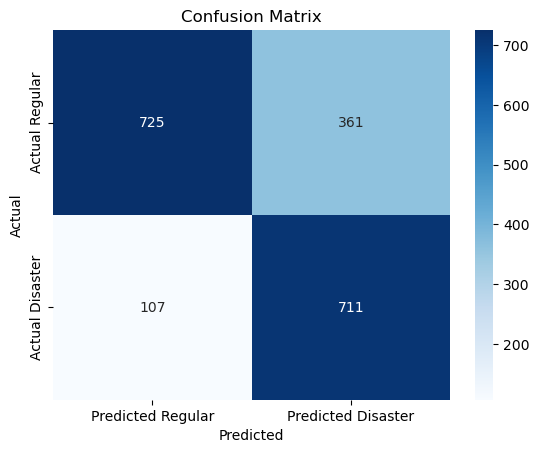

C:\Users\kalya\AppData\Local\Temp\ipykernel_18124\89303231.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


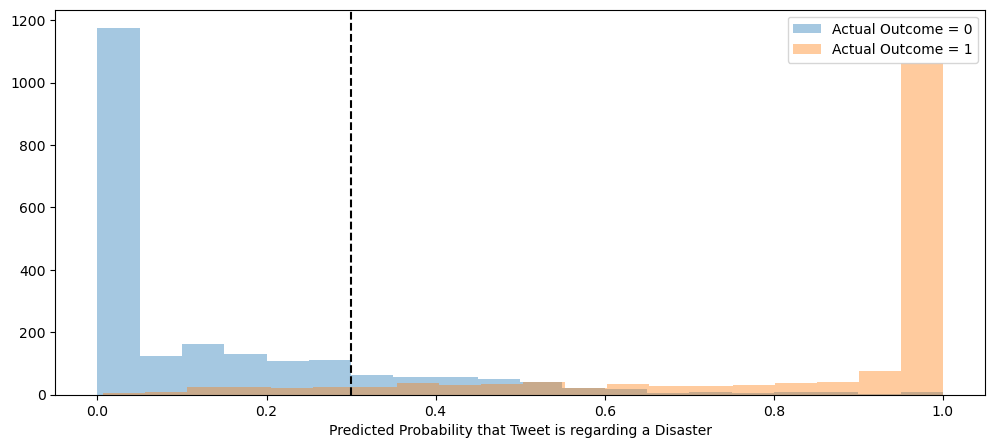

In [19]:
keras_evaluations(model, X_test, y_test, decision_boundary=0.3)

### Plot of accuracy as epochs increase for 20 epochs -- don't run this cell it was made with a previous training(20 epochs)

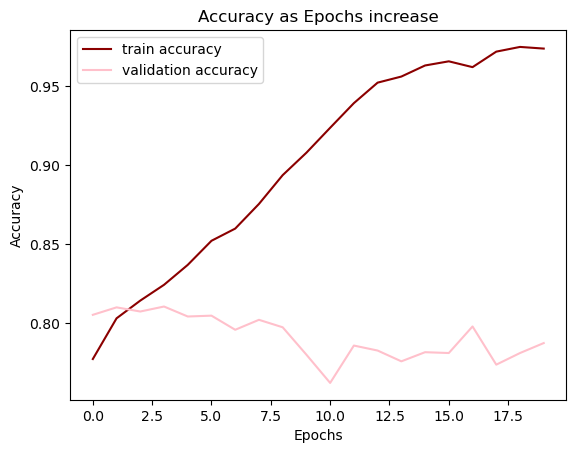

In [47]:
plt.plot(epoch_plotting.history['accuracy'], label='train accuracy',  color='darkred')
plt.plot(epoch_plotting.history['val_accuracy'], label='validation accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim((0,1))
plt.title('Accuracy as Epochs increase')
plt.legend();

### Bidirectional LSTM without GloVe Embeddings

In [35]:

# Train test split with actual data leakage respect
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    train['text_cleaned'], 
    np.asarray(train['target']), 
    random_state = 214, # north dfw rep
    stratify=labels # class imbalance
    )


# Max number of words
vocab_size = 10_000
# Word Vector dimension
embedding_dim = 64
# Max length of the sequence
max_length = 25
# Where to chop off the seq
trunc_type = 'post'
# Where to put padding
padding_type = 'post'


tokenizer_2 = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer_2.fit_on_texts(X_train_2)

train_seq = tokenizer_2.texts_to_sequences(X_train_2)
test_seq = tokenizer_2.texts_to_sequences(X_test_2)


train_padded = pad_sequences(
    train_seq,
    maxlen=max_length,
    padding= padding_type,
    truncating = trunc_type
    )

test_padded = pad_sequences(
    test_seq,
    maxlen = max_length,
    padding = padding_type,
    truncating = trunc_type
    )


Model

In [36]:
model_2 = Sequential()
model_2.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_2.add(Bidirectional(LSTM(64, return_sequences = True)))
model_2.add(Bidirectional(LSTM(32)))
model_2.add(Dense(1, activation = 'sigmoid')) # binary classification

model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 25, 64)            640000    
                                                                 
 bidirectional_12 (Bidirect  (None, 25, 128)           66048     
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 747329 (2.85 MB)
Trainable params: 747329 (2.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
model_2.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])

# es = EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=3,
#     verbose=0,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
#     start_from_epoch=0,
# )


history_2 = model_2.fit(
    train_padded,
    y_train_2,
    validation_data = (test_padded, y_test_2),
    batch_size = 256,
    epochs = 10,
    #callbacks = [es]
    )

Epoch 1/10
23/23 [==============================] - 10s 164ms/step - loss: 0.6693 - acc: 0.5803 - val_loss: 0.6123 - val_acc: 0.6880
Epoch 2/10
23/23 [==============================] - 2s 103ms/step - loss: 0.4533 - acc: 0.8171 - val_loss: 0.4510 - val_acc: 0.8030
Epoch 3/10
23/23 [==============================] - 2s 104ms/step - loss: 0.2606 - acc: 0.9056 - val_loss: 0.4954 - val_acc: 0.7910
Epoch 4/10
23/23 [==============================] - 2s 103ms/step - loss: 0.1709 - acc: 0.9420 - val_loss: 0.5759 - val_acc: 0.7726
Epoch 5/10
23/23 [==============================] - 2s 103ms/step - loss: 0.1317 - acc: 0.9555 - val_loss: 0.6192 - val_acc: 0.7390
Epoch 6/10
23/23 [==============================] - 2s 105ms/step - loss: 0.1041 - acc: 0.9693 - val_loss: 0.6305 - val_acc: 0.7463
Epoch 7/10
23/23 [==============================] - 2s 104ms/step - loss: 0.0887 - acc: 0.9743 - val_loss: 0.7636 - val_acc: 0.7453
Epoch 8/10
23/23 [==============================] - 2s 102ms/step - loss: 0

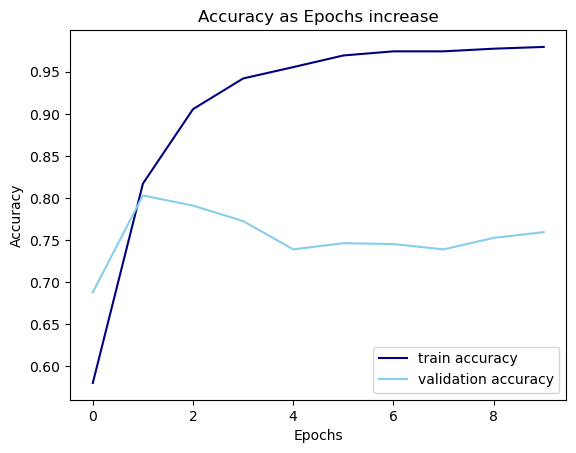

In [40]:
plt.plot(history_2.history['acc'], label='train accuracy',  color='navy')
plt.plot(history_2.history['val_acc'], label='validation accuracy',color='skyblue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim((0,1))
plt.title('Accuracy as Epochs increase')
plt.legend();

### Bidirectional LSTM without GloVe Embeddings and added Dropout

In [41]:
# Train test split with actual data leakage respect
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    train['text_cleaned'], 
    np.asarray(train['target']), 
    random_state = 214, # north dfw rep
    stratify=labels # class imbalance
    )

# Max number of words
vocab_size = 10_000
# Word Vector dimension
embedding_dim = 64
# Max length of the sequence
max_length = 25
# Where to chop off the seq
trunc_type = 'post'
# Where to put padding
padding_type = 'post'


tokenizer_3 = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer_3.fit_on_texts(X_train_3)

train_seq = tokenizer_3.texts_to_sequences(X_train_3)
test_seq = tokenizer_3.texts_to_sequences(X_test_3)


train_padded = pad_sequences(
    train_seq,
    maxlen=max_length,
    padding= padding_type,
    truncating = trunc_type
    )

test_padded = pad_sequences(
    test_seq,
    maxlen = max_length,
    padding = padding_type,
    truncating = trunc_type
    )


model_3 = Sequential()
model_3.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_3.add(Bidirectional(LSTM(64, return_sequences = True)))
model_3.add(Bidirectional(LSTM(32)))
model_3.add(Dropout(0.5))
model_3.add(Dense(1, activation = 'sigmoid')) # binary classification

model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 25, 64)            640000    
                                                                 
 bidirectional_14 (Bidirect  (None, 25, 128)           66048     
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 747329 (2.85 MB)
Trainable params: 74732

In [42]:
model_3.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])

# es = EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=3,
#     verbose=0,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
#     start_from_epoch=0,
# )


history_3 = model_3.fit(
    train_padded,
    y_train_3,
    validation_data = (test_padded, y_test_3),
    batch_size = 256,
    epochs = 10,
    #callbacks = [es]
    )

Epoch 1/10
23/23 [==============================] - 12s 231ms/step - loss: 0.6805 - acc: 0.5689 - val_loss: 0.6680 - val_acc: 0.5709
Epoch 2/10
23/23 [==============================] - 4s 161ms/step - loss: 0.5522 - acc: 0.7085 - val_loss: 0.5222 - val_acc: 0.7799
Epoch 3/10
23/23 [==============================] - 4s 162ms/step - loss: 0.2875 - acc: 0.8928 - val_loss: 0.5058 - val_acc: 0.7878
Epoch 4/10
23/23 [==============================] - 4s 160ms/step - loss: 0.1819 - acc: 0.9397 - val_loss: 0.5719 - val_acc: 0.7642
Epoch 5/10
23/23 [==============================] - 4s 160ms/step - loss: 0.1287 - acc: 0.9583 - val_loss: 0.6193 - val_acc: 0.7652
Epoch 6/10
23/23 [==============================] - 4s 161ms/step - loss: 0.1037 - acc: 0.9665 - val_loss: 0.6840 - val_acc: 0.7432
Epoch 7/10
23/23 [==============================] - 4s 159ms/step - loss: 0.0849 - acc: 0.9730 - val_loss: 0.7912 - val_acc: 0.7411
Epoch 8/10
23/23 [==============================] - 4s 158ms/step - loss: 0

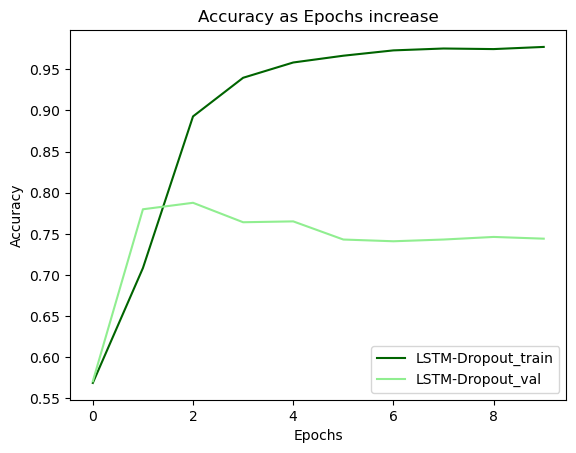

In [43]:
plt.plot(history_3.history['acc'], label='LSTM-Dropout_train',  color='darkgreen')
plt.plot(history_3.history['val_acc'], label='LSTM-Dropout_val',color='lightgreen')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim((0,1))
plt.title('Accuracy as Epochs increase')
plt.legend();

Save the history of 20 epochs for later so that we can get nice graphs

#### first, testing to see if model.predict works as expected for just 1 tweet

a function to clean tweets and put them in a format for the model to predict with

In [48]:
def tweet_to_input(tweet,tokenizer=tokenizer):
  '''
  Function that transforms asingle tweet(string) into an input for the model that was trained with a particular tokenizer
  input: tweet = single tweet that is a string
         tokenizer = tensorflow tokenizer used to train the model that we are getting predicitons from

  output: input array for model of shape (,max_padded_sequence_length)  aka (1,25) for this particular model

  requires:
            - tweet_cleaner() custom function
            - tensorflow.keras.preprocessing.Tokenizer object that was used in model training
            - pad_sequences() function from tensorflow.keras.preprocessing.sequence

  '''

  cleaned_tweet = list(map(tweet_cleaner,[tweet]))

  sequence = tokenizer.texts_to_sequences(cleaned_tweet)

  padded_array = pad_sequences(sequence, maxlen=25)

  return padded_array



In [51]:
inp = tweet_to_input("Israel-Hamas war rages as Palestinian death toll rises in Gaza: Live updates" ,tokenizer=tokenizer)

model.predict(inp)[0][0]

1/1 [==============================] - 0s 27ms/step


0.99673754

In [44]:
with open('../pickles/arjun_model_3.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('../pickles/tokenizer_arjun_v1.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)


# Model Comparison

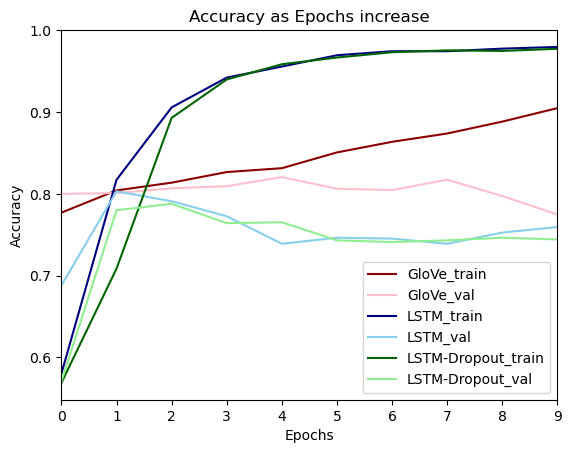

In [62]:
plt.plot(history.history['accuracy'], label='GloVe_train',  color='darkred')
plt.plot(history.history['val_accuracy'], label='GloVe_val',color='pink')
plt.plot(history_2.history['acc'], label='LSTM_train',  color='navy')
plt.plot(history_2.history['val_acc'], label='LSTM_val',color='skyblue')
plt.plot(history_3.history['acc'], label='LSTM-Dropout_train',  color='darkgreen')
plt.plot(history_3.history['val_acc'], label='LSTM-Dropout_val',color='lightgreen')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim((0,1))
plt.xlim((0,9))
plt.title('Accuracy as Epochs increase')
plt.legend();

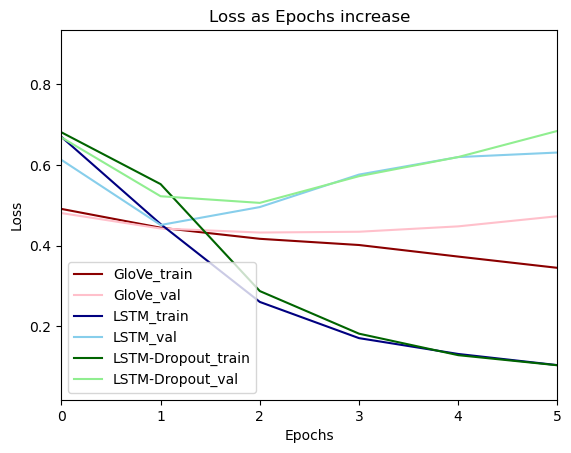

In [64]:
plt.plot(history.history['loss'], label='GloVe_train',  color='darkred')
plt.plot(history.history['val_loss'], label='GloVe_val',color='pink')
plt.plot(history_2.history['loss'], label='LSTM_train',  color='navy')
plt.plot(history_2.history['val_loss'], label='LSTM_val',color='skyblue')
plt.plot(history_3.history['loss'], label='LSTM-Dropout_train',  color='darkgreen')
plt.plot(history_3.history['val_loss'], label='LSTM-Dropout_val',color='lightgreen')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim((0,1))
plt.xlim((0,5))
plt.title('Loss as Epochs increase')
plt.legend();